# Week 10 - Probabilistic PCA

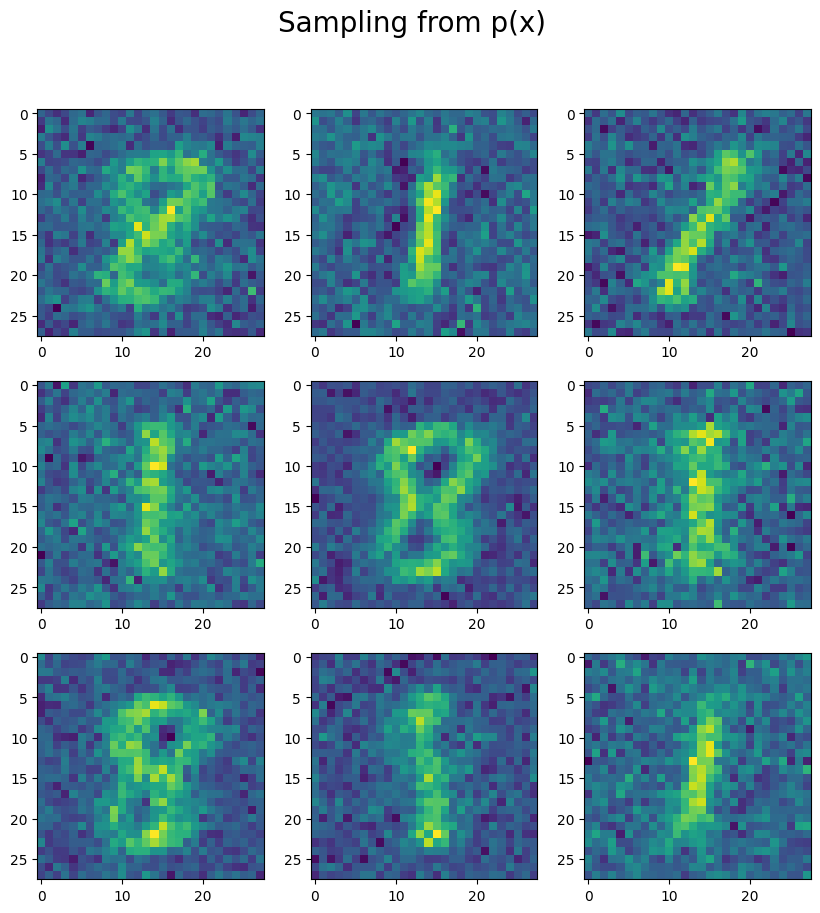

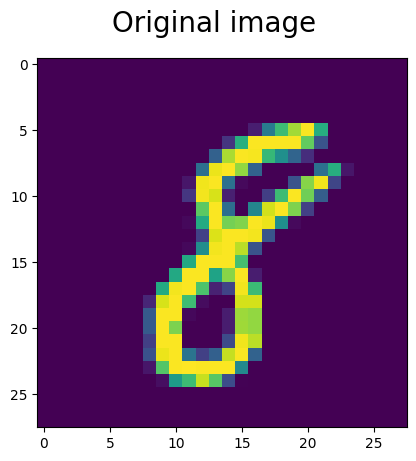

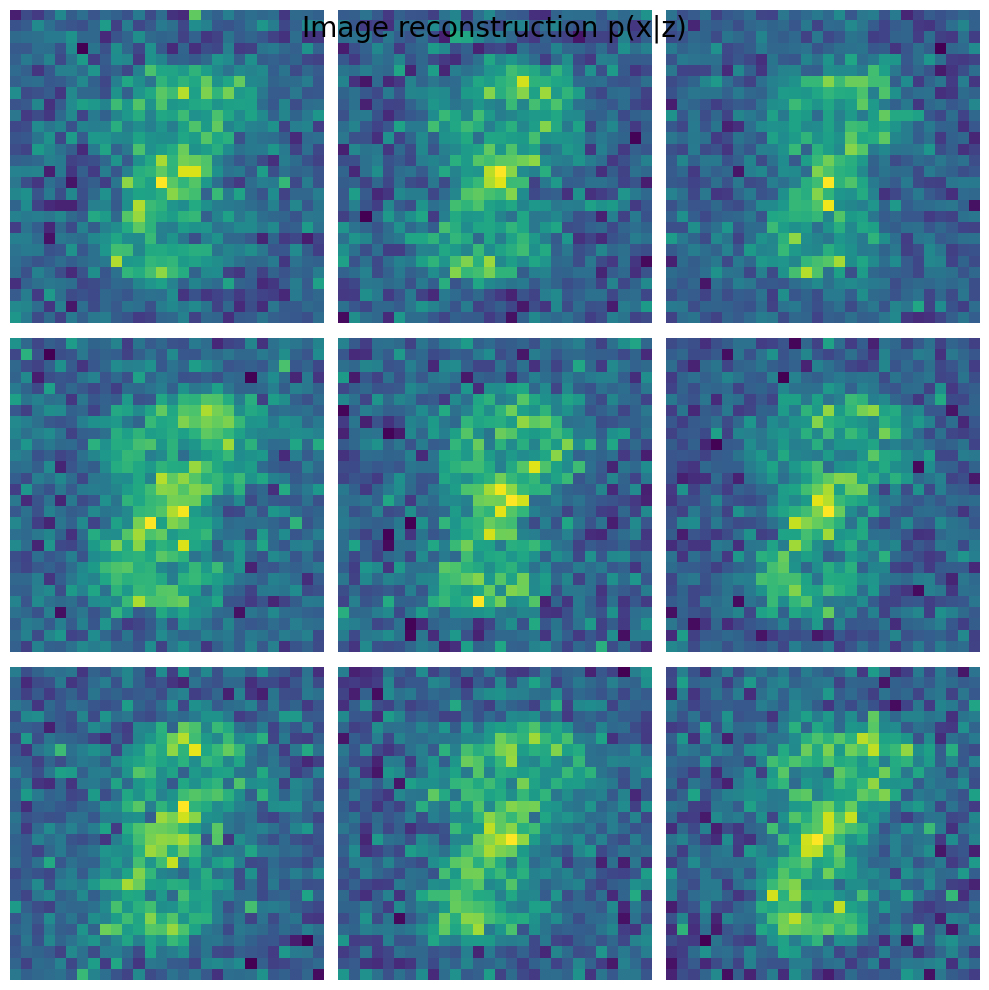

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.datasets import fetch_openml

class PPCA():
    '''
    X - dataset
    x - data point
    z - laten variable
    
    '''
    def __init__(self,X, M):
        self.D = X.shape[1] # dimension of oryginal data points   
        self.M = M # dimension of reduced data point
        self.X = X #dataset
        self.calculate_parameters()
    def calculate_parameters(self):
        '''
        Determine parameteres of the model (mean, variance and W matrix). 
        Have to be overriden in child classes
        '''
        raise NotImplementedError 
    def sample_x(self):
        '''
        Sample from p(x) distribution
        '''
        mean = self.mean
        C = np.dot(self.W_ML, self.W_ML.T) + self.sigma * np.eye(self.D)
        distribution = stats.multivariate_normal(mean, C)
        return distribution.rvs()
    def sample_z(self):
        '''
        Sample from p(z) distribution
        '''
        distribution = stats.multivariate_normal(np.zeros(shape = self.M), np.eye(self.M))
        return distribution.rvs()
    def sample_x_given_z(self, z):
        '''
        Sample from p(x|z) distribution'
        '''
        distribution = stats.multivariate_normal(np.dot(self.W_ML, z) + self.mean, self.sigma * np.eye(self.D))
        return distribution.rvs()
    def sample_z_given_x(self, x):
        '''
        Sample from p(z|x) distribution
        '''
        M_matrix = np.dot(self.W_ML.T, self.W_ML) + self.sigma * np.eye(self.M)
        M_matrix_inv = np.linalg.inv(M_matrix)
        mean = np.linalg.multi_dot([M_matrix_inv, self.W_ML.T, (x - self.mean)])
        variance = self.sigma * M_matrix_inv                                    
        distribution = stats.multivariate_normal(mean, variance)
        return distribution.rvs()
                                       

# ## Closed-form solution (CF)

class PPCA_CF(PPCA):
    '''
    X - dataset
    x - data point
    z - laten variable
    
    '''        
    def calculate_parameters(self):
        '''
        Determine parameteres of the model by optimizing likelihood function. 
        It involves caltulating mean, variance and W matrix.
        '''
        self.mean = self.X.mean(axis = 0)
        
        covariance = np.cov(self.X, rowvar = False)
        eig_val, eig_vec = np.linalg.eig(covariance)
        idx = np.argsort(eig_val)[::-1]
        eig_val = np.real(eig_val[idx])
        eig_vec = np.real(eig_vec[:, idx])
        
        self.sigma = 1/(self.D - self.M) * np.sum(eig_val[self.M+1:])
        
        U_M = eig_vec[:, :self.M]
        L_M = np.diag(eig_val[:self.M])
        self.W_ML = np.dot(U_M, np.sqrt(L_M - self.sigma*np.eye(self.M)))
                                        
        
        
if __name__ == "__main__":
    # Sample from p(x) distribution


    # Fetch MNIST data
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)

    # Extract data and labels
    x_train, y_train = mnist['data'], mnist['target']

    x_train = x_train / 255
    x_train = x_train.reshape(70000, -1)
    x_train = x_train[((y_train == '8') + (y_train == '1')),:]
    y_train = y_train[((y_train == '8') + (y_train == '1'))]

    model = PPCA_CF(x_train, 2)

    # sample from p(x)
    plt.figure(figsize =(10,10))
    for i in range(1,10):
        plt.subplot(3,3,i)
        plt.imshow(model.sample_x().reshape(28,28))
    plt.suptitle('Sampling from p(x)', fontsize=20)

    # Show the original image
    plt.figure()
    idx = np.random.randint(0, x_train[0].shape[0])
    plt.imshow(x_train[idx,:].reshape(28,28))
    plt.suptitle('Original image', fontsize=20)

    # Show the reconstructions

    z = model.sample_z_given_x(x_train[idx,:]) # get latent variable p(z|x)

    plt.figure(figsize =(10,10))
    for i in range(1,10):
        plt.subplot(3,3,i)
        image = model.sample_x_given_z(z)
        plt.imshow(image.reshape(28,28))
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle('Image reconstruction p(x|z)', fontsize=20)
    plt.show()
